Nur nen test zu autoencodern

In [2]:
%config InlineBackend.figure_format = 'retina'

In [5]:
import tensorflow.keras as keras
from keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
# load images + class
images = pd.read_pickle('images_flatten.pkl').to_numpy()
image_size = images[0][1].size
image_shape = (216,334,3) # height, width , channels
x_train,x_test = train_test_split(images[:, 1:],test_size=0.2) 
x_train = np.vstack(x_train[:, 0]).astype('float32') / 255. # normalized, cause just better
x_test = np.vstack(x_test[:, 0]).astype('float32') / 255.

all_data = np.vstack(images[:, 1:][:, 0]).astype('float32') / 255.

In [7]:
# very very simple 1 layer autoencoder
#encoded_dimension = 10

#input_img = keras.Input(shape=(image_size,))
#encoded = layers.Dense(encoded_dimension,activation='relu')(input_img)
#decoded = layers.Dense(image_size,activation='sigmoid')(encoded)

# model that maps input to guessed output
#autoencoder = keras.Model(input_img,decoded)

# model that maps input to the "compressed" representation
#encoder = keras.Model(input_img,encoded)

# model that maps representation to output
#encoded_input = keras.Input(shape=(encoded_dimension,))
#decoded_output = autoencoder.layers[-1](encoded_input) # same as layers.Dense(image_size,activation='sigmoid')(encoded_input) but retrived from other model
#decoder = keras.Model(encoded_input,decoded_output)

# cnn as en/decoder
shapes = image_shape

input_img = keras.Input(shape=shapes)

x = layers.Conv2D(64, (7, 7), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
#encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
#x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(encoded)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(shapes[2], (7, 7), activation='sigmoid', padding='same')(x)
#add cropping layer to match shapes
decoded=layers.Cropping2D(cropping=((0,0),(0,2)))(x)

autoencoder = keras.Model(input_img,decoded)
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# reshape into image shape
stacked_train = x_train.reshape((x_train.shape[0],image_shape[0],image_shape[1],image_shape[2]))
stacked_test = x_test.reshape((x_test.shape[0],image_shape[0],image_shape[1],image_shape[2]))

autoencoder.summary()

# train on data
autoencoder.fit(stacked_train,stacked_train,
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_split=0.2
               )

# predict some images
#encoded_imgs = encoder.predict(x_test)
#decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = autoencoder.predict(stacked_test)
print(decoded_imgs.size)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 216, 334, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 216, 334, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 167, 64)      0         


2023-12-15 19:03:04.138407: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-15 19:03:04.138442: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-15 19:03:04.138453: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-15 19:03:04.138502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-15 19:03:04.138520: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 167, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 84, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 84, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 54, 84, 32)        4128      
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 84, 32)        4128      
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 84, 32)        9248      
                                                                 
 up_sampli

2023-12-15 19:03:06.310712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [6]:
#print(decoded_imgs)
autoencoder.save('test_autoencoder_cnn.keras')

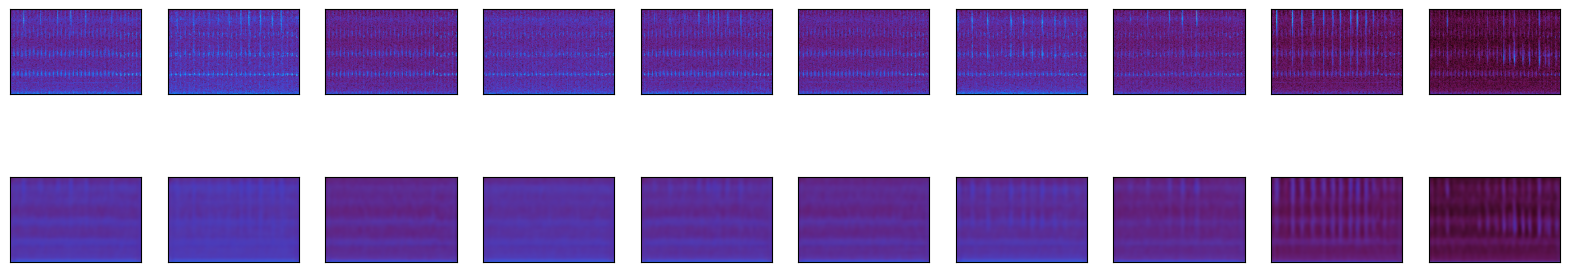

In [7]:
autoencoder = keras.saving.load_model('test_autoencoder_cnn.keras')
# display some of the images vs reconstruction
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(stacked_test[i].reshape(image_shape))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(image_shape))
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("test_autoencoder_cnn_reconstruction.png",dpi=600)